# DevDay 02: Challenges with real-world data

In [41]:
import pandas as pd
import sys
import os

from typing import TypeVar, Any

import matplotlib.pyplot as plt 

from data.impute_data import impute

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("."), "..")))
#
# from data.electricity_consumption import energy_demand
from data.india_pollution import india_pollution
from data.dataset import Dataset

## Missing and irregularly spaced data
Time series data might have missing values or unevenly spaced timestamps. To handle this, you can use interpolation methods or resampling techniques provided by the pandas library.


1. **Pandas interpolate**: Pandas `interpolate()` function is used to fill missing values in a dataset by using various interpolation techniques, such as linear, polynomial, or spline interpolation. It's useful when you have a small number of missing values in a time series and want to fill them based on the pattern of the surrounding data points. It's especially useful when the missing data points are located between existing data points with a clear pattern.

2. **Pandas resample**: Pandas `resample()` function is used to change the frequency of the time series data by aggregating or downsampling the data points. It's useful when you have irregularly spaced data or want to change the granularity of the dataset (e.g., from daily to monthly data). You can choose the resampling method, such as mean, sum, or max, to aggregate the data during resampling. This method is particularly helpful when you need to align time series data with different frequencies or fill gaps in irregularly spaced data.

3. **MICE (Multiple Imputation by Chained Equations)**: MICE is an advanced statistical method for imputing missing data by performing multiple imputations. It works by creating multiple copies of the dataset, filling the missing values in each copy using a regression model, and then averaging the results to obtain a single imputed dataset. MICE is useful when you have a large number of missing values or when the missing data is not missing at random. It's particularly helpful when you need to preserve the relationships between variables and account for the uncertainty in the imputed values.


In [42]:
# load the data
city_name = "Chennai"
dataset_object = next(india_pollution(city_list=[city_name], raw=True))

# get the data from the Dataset object
data = dataset_object.values

print(data.head())



INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists
INFO:root:Getting list of city names
INFO:root:Path /Users/frankkelly/Dropbox/Projects-new/india_air_pollution_study/data/air-quality-data-in-india exists


            PM2.5  PM10     O3    CO    SO2    NO2
Date                                              
2015-01-01    NaN   NaN  11.35  1.17   9.20  15.39
2015-01-02    NaN   NaN   9.16  1.23   8.61  13.42
2015-01-03    NaN   NaN  13.45  0.77  48.23  19.56
2015-01-04    NaN   NaN  10.33  1.00  27.96  16.20
2015-01-05    NaN   NaN   9.36  0.90  16.60  16.30


In [72]:
def plot_indian_city_pollution(df: pd.DataFrame, title: str = "Indian city pollution", 
                               scale: bool = False, chosen_metric: str = "PM2.5",
                               set_y_axis_limits: Any = None) -> None:
    """Plots the Indian pollution DataFrame, highlighting any gaps in the data."""
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Find the gaps in the data
    gap = df[chosen_metric].isnull().astype(int)
    gaps = gap[gap == 1]
    
    plt.plot(df.index, df[chosen_metric])
    
    # Highlight gaps in the data
    if gaps.shape[0] > 0:
        for gap_start, gap_end in zip(gaps.index[:-1], gaps.index[1:]):
            if gap_start != gap_end:
                ax.axvspan(gap_start, gap_end, color='red', alpha=0.2)
    else:
        print("No gaps in data")
    
    plt.xlabel("Date")
    if scale:
        plt.ylabel(f"{chosen_metric}, scaled")
    else:
        plt.ylabel(f"{chosen_metric}, micrograms per cubic meter")


    # Add a legend including the red area
    if gaps.shape[0] > 0:
        plt.legend([f"{chosen_metric}", "Missing data"])
    else:
        plt.legend([f"{chosen_metric}"])

    if set_y_axis_limits is not None:
        plt.ylim(set_y_axis_limits)

    if title is not None:
        title_string = f"{title} - {chosen_metric} for {city_name}"
    else:
        title_string = f"{chosen_metric} for {city_name}"

    plt.title(title_string)
    plt.show()

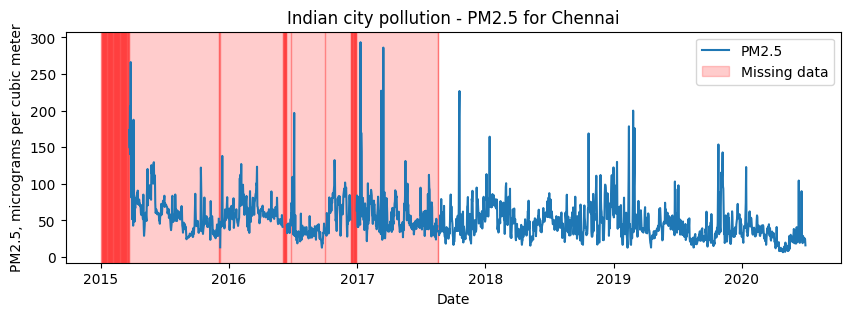

In [73]:
plot_indian_city_pollution(data, scale=False)

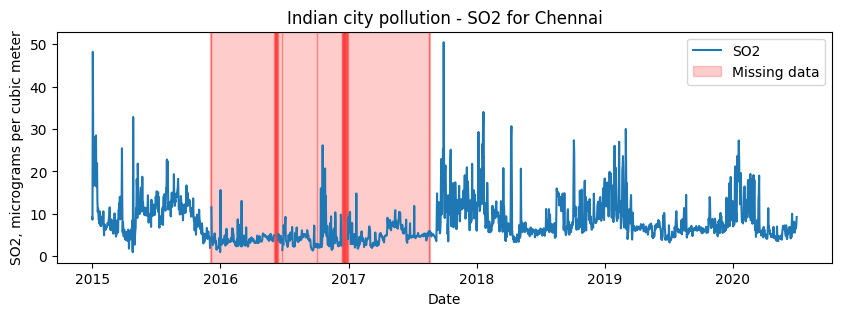

In [74]:
plot_indian_city_pollution(data, scale=False, chosen_metric="SO2")

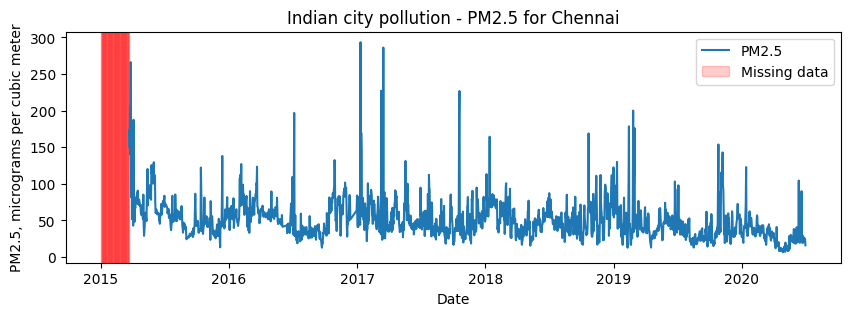

In [75]:
# Approach 1: Basic interpolation with Pandas

# Interpolate the data
data_interpolated = data.interpolate(method="linear")

# Plot the data
plot_indian_city_pollution(data_interpolated, scale=False,)

INFO:root:Imputing data for columns Index(['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2'], dtype='object')
INFO:root:columns present: Index(['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2'], dtype='object')
INFO:root:Shape of dataframe before imputation: (2009, 6)
INFO:root:Column PM2.5 has 117; more than 5% missing values, less than 50%, so advanced imputation is necessary
INFO:root:Column PM10 has 1707; less than 5% missing values, so only simple imputation is necessary
INFO:root:Column O3 has 49; less than 5% missing values, so only simple imputation is necessary
INFO:root:Column CO has 25; less than 5% missing values, so only simple imputation is necessary
INFO:root:Column SO2 has 36; less than 5% missing values, so only simple imputation is necessary
INFO:root:Column NO2 has 36; less than 5% missing values, so only simple imputation is necessary
INFO:root:Imputation is necessary
INFO:root:Imputing data with miceforest
INFO:root:Shape of dataframe after imputation: (2009, 6)


No gaps in data


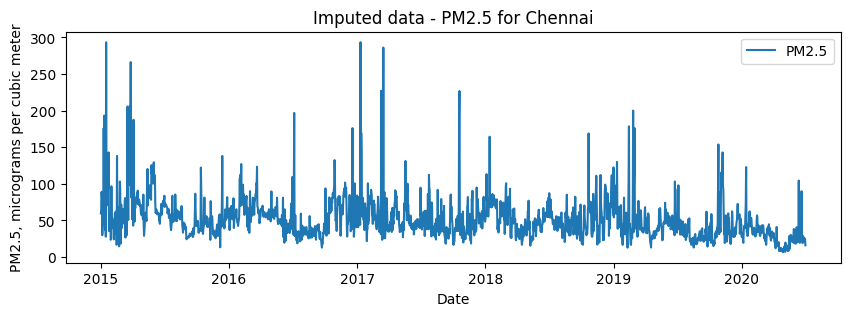

In [77]:
# Approach 2: Interpolation with MICE (Multivariate Imputation by Chained Equations)

# Impute the data
data_imputed = impute(data, target_columns=data.columns)

# Plot the data
plot_indian_city_pollution(data_imputed, scale=False, title="Imputed data")

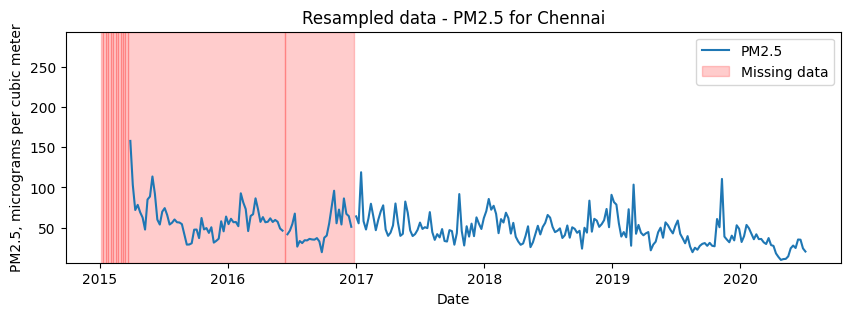

In [78]:
# Approach 3: Resampling to ensure that the data is at a regular frequency

# Resample the data
data_resampled = data.resample("w").mean()

# Plot the data
plot_indian_city_pollution(data_resampled, scale=False, title="Resampled data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))

In [16]:
# show the data
data.head()

,PM2.5,PM10,O3,CO,SO2,NO2
Date,,,,,,
2015-01-01,NaN,NaN,11.35,1.17,9.20,15.39
2015-01-02,NaN,NaN,9.16,1.23,8.61,13.42
2015-01-03,NaN,NaN,13.45,0.77,48.23,19.56
2015-01-04,NaN,NaN,10.33,1.00,27.96,16.20
2015-01-05,NaN,NaN,9.36,0.90,16.60,16.30


# Noise and outliers
 Real-world time series data often contains noise or outliers that can negatively impact forecasting accuracy. You can use rolling window functions with pandas to smooth the data and reduce the impact of noise.

## Moving average
A moving average can help to smooth out random noise in time series data. It calculates the average of a specified number of data points and slides this window over the data to produce a smoothed version of the original time series.

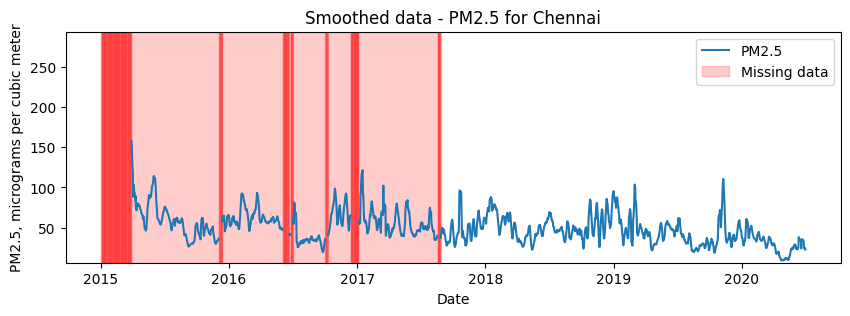

In [79]:
# Moving average to smooth the data

# Resample the data
data_smoothed = data.rolling(7).mean()

# Plot the data
plot_indian_city_pollution(data_smoothed, scale=False, title="Smoothed data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))


## Exponential smoothing to smooth the data
Exponential smoothing assigns exponentially decreasing weights to past observations, making it more responsive to recent changes in the data. It can be useful for reducing the impact of noise and outliers.

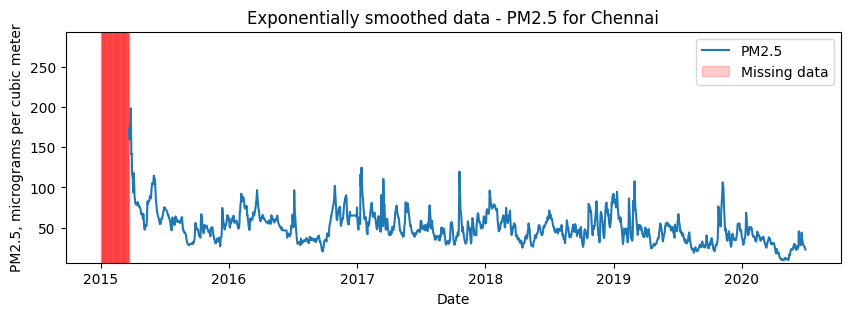

In [80]:
# Exponential smoothing to smooth the data

data_exp_smoothed = data.ewm(span=7).mean()

# Plot the data
plot_indian_city_pollution(data_exp_smoothed, scale=False, title="Exponentially smoothed data",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))

# Z-score method to remove outliers
The Z-score method can be used to detect and remove outliers based on the standard deviation of the data. Data points with a Z-score higher than a specified threshold (e.g., 2 or 3) can be considered outliers.

filtered_entries: Date
2015-01-01    False
2015-01-02    False
2015-01-03    False
2015-01-04    False
2015-01-05    False
              ...  
2020-06-27     True
2020-06-28     True
2020-06-29     True
2020-06-30     True
2020-07-01     True
Freq: D, Name: PM2.5, Length: 2009, dtype: bool
No gaps in data


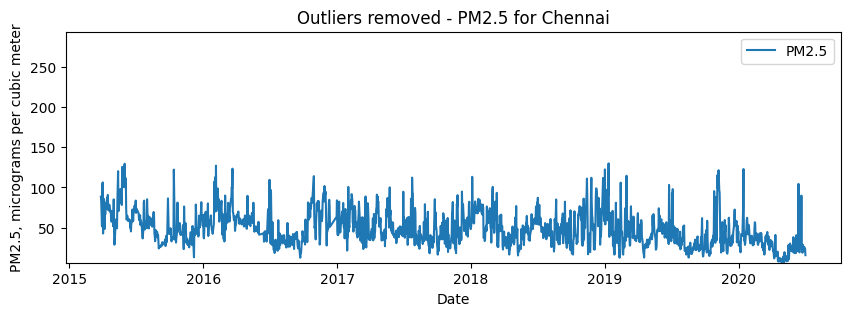

In [81]:
# Z-score method to remove outliers (PM2.5)

import numpy as np

threshold = 3

z_scores = (data["PM2.5"] - data["PM2.5"].mean()) / data["PM2.5"].std()
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < threshold)
print(f"filtered_entries: {filtered_entries}")

data_outliers_removed = data[filtered_entries]

# Plot the data
plot_indian_city_pollution(data_outliers_removed, scale=False, title="Outliers removed",
                           set_y_axis_limits=(data["PM2.5"].min(), data["PM2.5"].max()))